# Reverberation Mapping
`SIROCCO` has the capability to generate transfer functions/reverberation signatures for the systems it models. These describe how a change in the ionising continuum is reprocessed into a change in line emission. These signatures can (approximately) be recovered from observation, if there's a sufficiently series of line spectra with sufficiently high time- and wavelength-resolution. 

The transfer function is the term $\Psi$ in the equation $L(v, t) = \int_0^\infty \Psi(v, \tau) C(t - \tau) d\tau$. `SIROCCO` can also generate response functions, $\Psi_r$, used in $\delta L(v, t) = \int_0^\infty \Psi_r(v, \tau) \delta C(t - \tau) d\tau$ (a more observationally-accessible property).


The paper discussing our implementation, and the differences between $\Psi$ and $\Psi_r$ are:

* Mangham 2018 [https://ui.adsabs.harvard.edu/abs/2017MNRAS.471.4788M/abstract]
* Mangham 2019 [https://ui.adsabs.harvard.edu/abs/2019MNRAS.488.2780M/abstract]

## 'Basic' Transfer Function
   
This example uses the `examples/basic/reverb.pf` file to generate the transfer function for a biconical outflowing disk wind around an AGN, driven by continuum emission of both X-rays from a spherical corona and UV emission from the hot inner regions of the accretion disk. 


### Building the Model

To generate the data for reverberation mapping, `SIROCCO` tracks the paths of photons as they travel throughout the wind, using them to build up a map of the response delay for each region of the wind. The settings to govern that can be found in the `### Parameters for Reverberation Modeling` section of the `.pf` file. 

#### reverb.pf
```
### Parameters for Reverberation Modeling (if needed)
Reverb.type(none,photon,wind,matom)               wind
Reverb.disk_type(correlated,uncorrelated,ignore)  ignore
Reverb.path_bins                                  100
Reverb.visualisation(none,vtk,dump,both)          none
Reverb.filter_lines(0=off,-1=continuum,>0=count)  -1
```

There are several `Reverb.type` modes that can be used for this, but the standard one is `wind`. This handles emission in the wind by assigning photons generated there a delay compared to the central source drawn from the distribution of delays of those photons that contributed to the heating & ionisation state of that region of the wind. This distribution is discretised in `Reverb.path_bins` bins; in this example we use `100` but `1000` is more suitable for real applications.

Values that are too low will result in clear 'striping' in the transfer functions, whilst values that are too high give no real benefit and result in increased memory overhead (as each cell in the wind contains a `path_bins`-length array of doubles).

#### Line Filtering

An important setting is `Reverb.filter_lines`. If this is set to `0`, *every* single photon that contributes to every single spectrum (including the pseudo-photons generated after each scattering event in `extract` mode). This produces unwieldy and incredibly vast output files! The `-1` filter mode instead includes only those photons whose last interaction was a line scatter or line emission. This produces large, but less overwhelming output files.

`Reverb.filter_lines N` allows the user to include `N` different `Reverb.filter_line X` lines, where `X` is the internal `SIROCCO` data file line number for the line. This is a bit clunky and is easiest done by exploring the output files. This exploratory process is covered later on. 

Ideally, this could be done in the input file by specifying the transition by species, upper and lower lines.

### Running the Model
If you'd like to run `SIROCCO` directly through this notebook, you'll have to make sure whatever virtual environment you're running it in has access to the `SIROCCO` executables, and set the notebook itself to be trusted using `jupyter trust reverb.ipynb`. Then:

In [ ]:
import subprocess
with open("reverb.txt", "w") as output_file:
    subprocess.run(['mpirun', '-np', '4', 'sirocco', 'reverb'], stdout=output_file, stderr=output_file)

Or alternatively, run it manually on the command line as:

```bash
mpirun -np 4 sirocco reverb &> reverb.txt
```


This will write one `reverb.delay_dump` file per thread, and concatenate them together. If run in serial you should see the following message once it finishes: 

```bash
cat: 'reverb_high.delay_dump[0-9]*': No such file or directory
rm: cannot remove 'reverb_high.delay_dump[0-9]*': No such file or directory
```

This can be ignored. Ideally, this would all be done directly to **HDF5** or **SQLite** or a similar file format but that's yet to be implemented.

### Processing the Data

Processing the data involves using the `py4py.reverb` module provided in the `py_progs` directory. You can install this into your virtual environment using `pip`. This works by processing the very large flat text `.delay_dump` files into a **SQLite** database for further processing. This is done by:

In [1]:
%matplotlib inline
from py4py.reverb import open_database

db = open_database('reverb')

Opening database 'reverb'...
Found existing filled photon database 'reverb'


You should see the output

```bash
Opening database 'reverb'...
No existing filled photon database, reading from file 'reverb.delay_dump': 
Successfully read in ([Time]s)
```

If there are errors during reading, this will leave a malformed `reverb.db` database- to restart generation with a fixed DB file, you'll have to delete the `reverb.db` file.

Once the database has been built, you can begin producing transfer functions. Each is only meaningful for a single emission line, so you need the `SIROCCO` line number. This is an internal number that depends on your choice of data files. In practical terms, the easiest way to determine it is to filter the output data file by its second (`Lambda`, wavelength in $\mathring{A}$) column to get the last (`Res.` for resonance) column, e.g. to find the $C_{IV}$ line you would do something like: 

```bash
 awk '{if($2<1551 && $2>1549)print}' < reverb.delay_dump 
```

This should give an output along the lines of the following:
```bash
1.9339e+15     1550.205  5.916e+35 +3.2373e+16 +2.527e+16 -2.0825e+15   0       0     2.3796e+06     0     3   417
1.9343e+15     1549.889 1.9913e+35 +1.456e+16 -2.1381e+15 +1.1648e+14   0       0     7.8831e+05     0     3   418
 1.934e+15     1550.089 3.7613e+35 +1.8536e+16 -2.8783e+15 +4.1224e+14   0       0     1.0195e+06     0     3   418
 1.934e+15     1550.078 1.3523e+36 -2.0765e+16 -2.4398e+16 +2.5734e+15   2       1     9.1914e+05     0    13   418
```
This would suggest that the doublet covers lines `417` and `418`. We can take this number and use it to generate a transfer function as 


In [2]:
from py4py.reverb import TransferFunction

c_4 = TransferFunction(db, 'C-IV', continuum=1e43+9.20e43, wave_bins=50, delay_bins=50) \
    .line(418, 1550) \
    .spectrum(1) \
    .delay_dynamic_range(3) \
    .run(limit=1000)

'C-IV' successfully run (0.0s)


The `TransferFunction` initialiser accepts several arguments:

- The database opened earlier, the name of the transfer function (in this case `C-IV`).

- The continuum luminosity used to generate it (central source **plus** disk continuum).

- The number of bins in time (`delay_bins`) and wavelength (`wave_bins`) for the transfer function.

The photons used to generate this transfer function are then limited by a set of functions:

- The `line()` function limits the produced transfer function to only include photons in the specific line. The wavelength of the line is also needed- ideally, it would be possible to get this straight from the `SIROCCO` atomic data files eventually. 

- As the data file contains multiple spectra, we select one with `spectrum()`, providing the spectrum number (1-indexed).

- The `delay_dynamic_range()` function limits the range of delays used to calculate the delay bins. Normally, the code will generate `delay_bins` number of bins between `0` and the longest delay in the dataset. However, for models with dense regions, there can be a very long tail of photon delays, such that setting the bins to include *all* photons means condensing 90%+ of the delay distribution into a small number of bins. Instead, the `delay_dynamic_range()` function caps the delay at the $1-10^{argument}$th percentile, i.e. `delay_dynamic_range(3)` means the transfer function will cover 99.9% of the range of photon delays.

- The `run()` function queries the photons on disk and bins them to produce the transfer function. The `limit` parameter caps the query at `argument` photons. As a full query can run to multiple minutes, you can run quick tests using the `limit` parameter!

Once the data has been processed using `run()`, you can plot it.

Plotting to file 'C-IV.eps'...
Total line: 4.490e-06
Successfully plotted 'C-IV.eps'(1.3s)


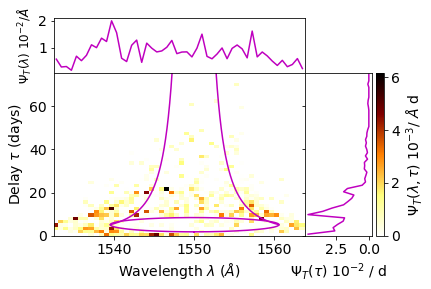

In [3]:
c_4.plot(
    format='png',
    keplerian={
        'angle': 40.0, 'mass': 1e7, 'radius': [1500, 3000]
    }
)

from ISIROCCO.display import Image
Image(filename='C-IV.png')

You can overlay a plot of the expected envelope for a Keplerian rotating disk by passing a dictionary as an argument to plot:

* **angle:** The angle of observation
* **mass:** The central object mass
* **radius:** The inner and outer disk radii in terms of the central object $r_g$ ($2\times r_\mathrm{schwartzchild}$)

By default, the transfer function is output to disk (as it can take a very long time to run and there's no point risking people accidentally not saving it!). Satisfied that the transfer function has been generated successfully and looks relatively OK, we can create one with the full dataset. If we call `run()` again without a `limit` parameter, the output TF will use the same delay and wavelength bins. We'll create a new one from scratch just to be sure (as the 99.9th% of the first 1000 photons may differ a bit from the full set). 

Given the previous TF appears to have a fairly long and weak outflow signature, it is reasonable to reduce the dynamic range a bit. The relatively small size of the input file as well means we should reduce the number of bins.

In [4]:
c_4 = TransferFunction(db, 'C-IV', continuum=1e43+9.20e43, wave_bins=15, delay_bins=15) \
    .line(418, 1550) \
    .spectrum(1) \
    .delays(0, 40) \
    .wavelengths(1500, 1600) \
    .run(scaling_factor=1/5)

'C-IV' successfully run (1.8s)


* Instead of using the dynamic range, we can set the delay range manually. We'll select 2000 days as most of the features fall in this range.
* The `scaling_factor` parameter is used to account for the fact that the full photon DB is built up of photons from many spectral cycles. You **must** provide a scaling factor equal to 1/`Spectrum_cycles`. Ideally, this would be caught from the input `.pf` file automatically.

Now we can actually plot the final transfer function. For this, we will pass the `velocity=True` argument to plot to show the velocity shift on the line emission:

Plotting to file 'C-IV.eps'...
Total line: 1.529e-04
Successfully plotted 'C-IV.eps'(1.0s)


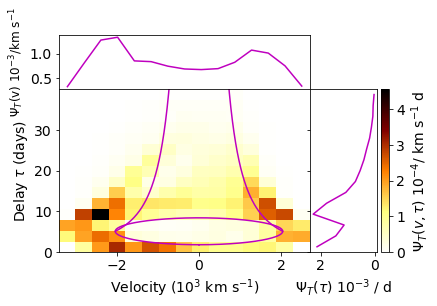

In [5]:
c_4.plot(
    format='png',
    keplerian={
        'angle': 40.0, 'mass': 1e7, 'radius': [1500, 3000]
    },
    velocity=True,
)

from ISIROCCO.display import Image
Image(filename='C-IV.png')

### Intepreting the Transfer Function

The velocity-delay plane projects information on both the kinematics and geometry of the system, but in a way that is not necessarily easy to interpret. Two-dimensional transfer functions have *less* degeneracy than one-dimensional ones, but not *no* degeneracy. In addition, different behavious may appear at different timescales; in particular, in systems with both outflow and rotation will exhibit unusual behaviour around the regions where the outflow and Keplerian velocities are equivalent.

* Diagonal features, with a 'gap' in the bottom-right section (highly red-shifted at short delays), a.k.a. blue-leads-red, are associated with outflows. 
    * Any highly red-shifted material has to have been reprocessed in the outflows heading away from the observer; thus, the travel time for this is longer.
    * These typically also have a gap in the top-left section of the transfer function (highly blue-shifted at short delays). In classic reverberation models this is a crisp, well-defined line. Taking multiple-scattering into account, photons from any position in the wind can be reprocessed again in the outflow region; so this region bleeds upwards. 
    * **However:** Be aware that these signatures might be convolved with rotation (see below).
* Oval features are associated with Keplerian rotation. 
  * 'Squashed' ovals, with high red- & blue-shift at short delays, are typically disk or wind inner edges of reprocessing material in Keplerian rotation. The closer material is to the central object, the faster it rotates. Again, classic reverberation models have very crisp edges to these signatures, but multiple-scattering will smear them out in our code.
  * 'Tall' ovals, with low red- & blue-shift at delays ranging from short to long, are typically disk or wind outer edges. As before, these signatures are less crisp than classical ones due to multiple-scattering. Emission typically falls off in the middle of the oval, and drops dramatically beyond it. 
    * If there is no distinct edge, just a smooth falloff, this is likely due to the reprocessing region extending off beyond the region at which the falloff due to distance from the central source reduces the response to zero.
  * **However:** Be aware that these signatures might be convolved with outflow (see below).
* 'Tilted tall' ovals are associated with Keplerian rotation convolved with outflow.
  * These arise due to the interaction between outflow and Keplerian rotation. Those regions that are furthest from the observer (i.e. at longest delays) are the most red-shifted, and those that are at short delays are the most blue-shifted.
  * See [Mangham 2018](https://arxiv.org/abs/1707.07687) for more details, as this is quite hard to explain without a good image.
  * Crucially, over short distances these can *appear* to display blue-leads-red signatures at low resolution.
  
The transfer function above shows clear signs of keplerian rotation with an oval inner-edge signature. However, there is no distinct longer-delay outer edge signature, suggesting that emission is not from a well-defined disk with a hard edge but that it tails out slowly. There is also a small blue-leads-red signature, more visible if the transfer function is plotted with a logarithmic response, with a slight 'diagonal' signature visible. This suggests that the kinematics of the emission region are largely rotationally-dominated with a hint of outflow. Notably, this does not imply that the entire system **itself** is rotationally dominated or in outflow, simply that the kinematics of the material that is emitting in $C_\mathrm{IV}$ are so.

If our initial run didn't provide enough detail, we can create a new file with more spectral cycles, and limit it to output only the photons we want to keep the file size down, for example as below to keep only the $C_\mathrm{IV}$ photons from the upper line of the doublet:

#### reverb_extended.py
```
### Parameters associated with photon number, cycles,ionization and radiative transfer options
[...]
Spectrum_cycles                            50
[...]

### Parameters for Reverberation Modeling (if needed)
[...]
Reverb.filter_lines                        1
Reverb.filter_line                         418
```

## Responsivity-Weighted Transfer Function

The basic transfer function generated is more properly the **'emissivity-weighted'** transfer function; it assumes that there are no changes in ionisation state in the wind, and that a 10% increase in central source luminosity results in a 10% increase in reprocessed luminosity in the wind. Given observations of the breathing BLR in AGN or of periods of anticorrelation between continuum and Hα luminosity in the AGN NGC5548, this is unlikely to be true!

`SIROCCO` can produce **responsivity-weighted** transfer functions, A.K.A 'response functions'. It does this by performing two separate runs of models that bracket the main model in luminosity, and approximates the response function at the central luminosity by using the gradient between the two transfer functions. We produce two copies of the main model, each with all sources of luminosity adjusted up and down by the same value. Typically we choose 10%, assuming that the responsivity is constant across this region. As the regions of peak response typically move through the wind with changing luminosity (e.g. ionisation fronts being pushed back when continuum luminosity increases), selecting too large a bracket can result in issues with the emitting wind regions failing to overlap.


### Building the Models

So we create two new copies of the file `reverb.pf`, `reverb_low.pf` and `reverb_high.pf`.

The original lines in reverb.pf are:

#### reverb.pf
```
### Parameters for the Disk (if there is one)
[...]
Disk.mdot(msol/yr)                         0.02
[...]

### Parameters for Boundary Layer or the compact object in an X-ray Binary or AGN
[...]
Central_object.luminosity(ergs/s)          1e43
[...]

### Parameters for Reverberation Modeling (if needed)
[...]
Reverb.filter_lines(0=off,-1=continuum,>0=count)   -1
```

In our low and high versions of the file (in the same directory), they are:

#### reverb_low.pf
```
### Parameters for the Disk (if there is one)
[...]
Disk.mdot(msol/yr)                         0.018
[...]

### Parameters for Boundary Layer or the compact object in an X-ray Binary or AGN
[...]
Central_object.luminosity(ergs/s)          0.9e43
[...]

### Parameters for Reverberation Modeling (if needed)
[...]
Reverb.filter_lines                        1
Reverb.filter_line                         418
```

#### reverb_high.pf
```
### Parameters for the Disk (if there is one)
[...]
Disk.mdot(msol/yr)                         0.022
[...]

### Parameters for Boundary Layer or the compact object in an X-ray Binary or AGN
[...]
Central_object.luminosity(ergs/s)          1.1e43
[...]

### Parameters for Reverberation Modeling (if needed)
[...]
Reverb.filter_lines                        1
Reverb.filter_line                         418
```
**NOTE:** You may have to change the `Reverb.filter_line` entry if the line number you found earlier is different. Line numbers *depend on the data files*, so any update to the data files may change the line numbers.

These two runs are used to calculate the response function. The final response function will *only* use the output of these two, and not use any of the photons used to generate the transfer function, so you may want to increase the number of photons run. However, for diagnostic purposes it's useful to generate a response functions from each pair (`-10% → +10%`, `-10% → 0%`, `0% → 10%`); any substantial differences between them will highlight that you're at a point of inflection in the ionisation profile.

Given we know which emission line number we're looking for now, we can set the filter to exclude all other photons from being stored using `Reverb.filter_lines`; this will dramatically reduce the file-size.

### Running the Models

Now, we run these two models as well. They'll similarly output one `reverb_[low/high].delay_dump[thread]` file per thread, which will be concatenated together at the end of the run to produce a single `reverb_[low/high].delay_dump` file.

In [ ]:
import os
os.system("mpirun -np 8 py reverb_low.pf > reverb_low.txt")
os.system("mpirun -np 8 py reverb_high.pf > reverb_high.txt")

You may want to change the number of processors used, depending on your system.

### Processing the Data

Now, we need to go back to the `py4py.reverb` package. Each one of the new runs needs to be processed into a **sqlite** database, and we can then produce a response function from them. We can base the analysis on the previously-made `TransferFunction` as

Opening database 'reverb_low'...
Found existing filled photon database 'reverb_low'
Templating 'C-IV_high' off of 'C-IV'...
'C-IV_high' successfully run (1.2s)
Opening database 'reverb_high'...
Found existing filled photon database 'reverb_high'
Templating 'C-IV_high' off of 'C-IV'...
'C-IV_high' successfully run (1.0s)
Plotting to file 'C-IV_resp.eps'...
Total response: 2.435e-03
Successfully plotted 'C-IV_resp.eps'(0.9s)


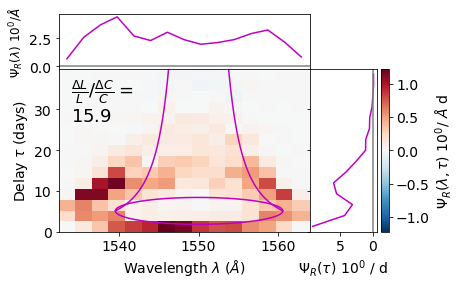

In [7]:
from py4py.reverb import TransferFunction

db_low = open_database('reverb_low')
c_4_low = TransferFunction(db_low, 'C-IV_high', template=c_4, continuum=0.9e43+8.29e43) \
    .delay_dynamic_range(2) \
    .run(scaling_factor=1/5)

db_high = open_database('reverb_high')
c_4_high = TransferFunction(db_high, 'C-IV_high', template=c_4, continuum=1.1e43+1.01e44) \
    .delay_dynamic_range(2) \
    .run(scaling_factor=1/5)

c_4.response_map_by_tf(c_4_low, c_4_high).plot(
    name='resp', format='png', response_map=True,
    keplerian={
        'angle': 40.0, 'mass': 1e7, 'radius': [1500, 3000]
    }
)
Image(filename='C-IV_resp.png')

* The `template=` argument is required to produce a response function. A templated `TransferFunction` will share the same wavelength and delay bins, along with the same line and spectrum.
* The argument `template_different_line=True` can be passed when declaring a new `TransferFunction`. This can be used to ensure consistency between e.g. $C_{IV}$ and $H\alpha$ transfer/response function plots. These will share the same *velocity* bins, delay bins and spectrum.
* Once the two `TransferFunction`s for the different continuum values have been generated, we subtract the two and divide by $\Delta C$. This assumes that the difference in line response is linear across $\Delta C$!
* Notably, whilst the response function data is stored on the template `TransferFunction` object, none of that object's transfer function data is used to calculate it.

### Interpreting the Response Function

Critically, unlike transfer functions, response functions can have both positive and negative regions. `py4py` by default uses <font color='darkred'>**red**</font> to indicate regions of positive response and <font color='darkblue'>**blue**</font> to indicate regions of negative response. 

* Naively, we would expect the response function to have the same distribution as the transfer function; if plotted with `rescaled=True` (such that the maximum value in any given bin is 1) the two should be identical. If the response profile of the wind differs at all across the interval $\Delta C$, then the response function should be different.
* As the luminosity of the central source increases, this can push ionisation fronts back into the wind. This can result in a <font color='darkblue'>**reduction**</font> in response at low delays and high Doppler shifts.
* It can also result in over-ionization of low-density extended wind regions. This shows most clearly as a <font color='darkblue'>**reduction**</font> in the response at long delays.
* In some models, there can in fact be a net negative response. It can be difficult to gauge this from the response function, but if this is the case it should be shown on the relative line increase against the global responsivity $\frac{\Delta L}{L}/\frac{\Delta C}{C}$. Naively, a 10% increase in continuum should result in a 10% increase in line luminosity giving a value of 1, a negative value indicates a reduction in line luminosity with increasing luminosity.

For a response function to work, both runs used to produce it need to fully sample the whole velocity-delay space, otherwise spurious positive and negative responses are visible based solely on the presence or absence of photons in any given bin.

This response function is relatively well-behaved. It closely tracks the emissivity map, indicating that (for this system) the traditional assumptions of reverberation mapping hold. The response is strong at low delays and around the line of Keplerian rotation, and line emissivity increases at a substantially higher rate than continuum emissivity. This suggests that the inner wind is in a relatively low ionisation state and that increasing luminosity affects it significantly, substantially increasing the proportion of $C_{IV}$.